In [8]:
import pandas as pd
import numpy as np
import load_data
from datetime import date

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
try:
    data = pd.read_csv('data_20181001-7.csv')
except OSError:
    r = load_data.RegionReport()
    data = r.download(date(2018, 10, 1), date(2018, 10, 7))
    data.to_csv('data_20181001-7.csv', index=False)

In [3]:
try:
    node_data = pd.read_csv('node_20181001-7.csv')
except OSError:
    r = load_data.NodePriceReport()
    node_data = r.download(date(2018, 10, 1), date(2018, 10, 7))
    node_data.to_csv('node_20181001-7.csv', index=False)

In [4]:
node_data = pd.merge(
    node_data,
    data[['region_id', 'date', 'hour', 'price_con']],
    on=['region_id', 'date', 'hour']
)

In [5]:
node_data['price'] = pd.to_numeric(node_data.price)
node_data.dropna(inplace=True)

<IPython.core.display.Javascript object>


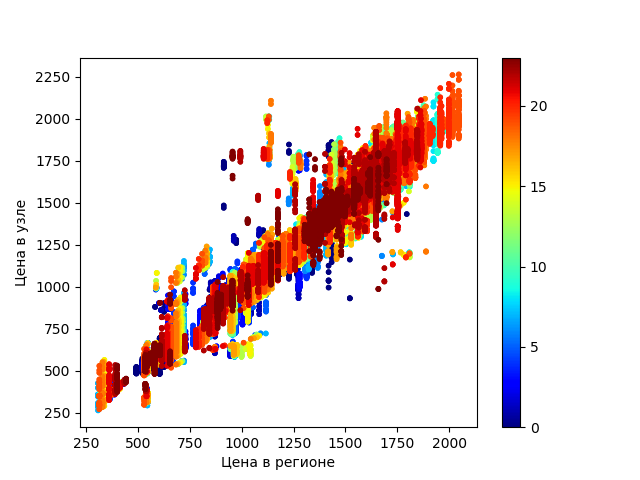

In [10]:
day_data = node_data[node_data.date == node_data.date.min()]
plt.scatter(day_data.price_con, day_data.price, c=day_data.hour, cmap=plt.get_cmap('jet'), marker='.')
#plt.plot([day_data.price_con.min(), day_data.price_con.max()], [day_data.price_con.min(), day_data.price_con.max()])
plt.colorbar();
plt.xlabel('Цена в регионе');
plt.ylabel('Цена в узле');
plt.savefig('pic/price1.png', transparent=True)

In [11]:
coefs = []
for node_id, d in node_data[['node_id', 'price_con', 'price']].groupby('node_id'):
    A = np.vstack([d.price_con, np.ones(d.shape[0])]).T
    k, b = np.linalg.lstsq(A, d.price)[0]
    coefs.append((node_id, k, b))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [12]:
coefs = pd.DataFrame(coefs, columns=['node_id', 'k', 'b'])

In [13]:
node_data = pd.merge(
    node_data,
    coefs,
    on=['node_id']
)

In [14]:
node_data['price_pred'] = node_data.price_con * node_data.k + node_data.b
node_data['dev'] = node_data.price - node_data.price_pred

<IPython.core.display.Javascript object>


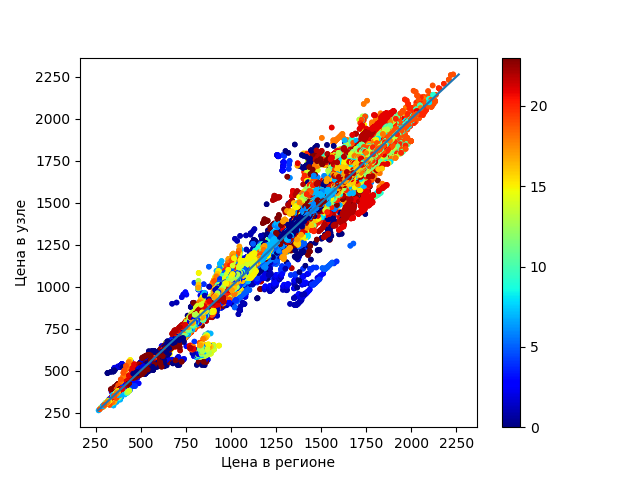

In [17]:
day_data = node_data[node_data.date == node_data.date.min()]
plt.scatter(day_data.price_pred, day_data.price, c=day_data.hour, cmap=plt.get_cmap('jet'), marker='.')
plt.plot([day_data.price.min(), day_data.price.max()], [day_data.price.min(), day_data.price.max()])
plt.colorbar()
plt.xlabel('Цена в регионе')
plt.ylabel('Цена в узле')
plt.savefig('pic/price2.png', transparent=True)

<IPython.core.display.Javascript object>


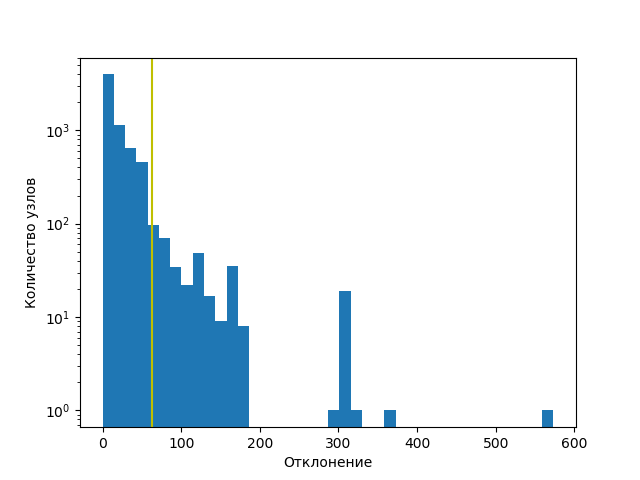

In [19]:
nodes = node_data.groupby('node_id')['dev'].std().fillna(0.0)
plt.hist(nodes, log=True, bins=40);
plt.axvline(x=nodes.quantile(0.95), c='y')
plt.xlabel('Отклонение')
plt.ylabel('Количество узлов')
plt.savefig('pic/price3.png', transparent=True)

In [20]:
node_ids = np.unique(nodes[nodes >= 200].index)
node_ids[0]

100406

<IPython.core.display.Javascript object>


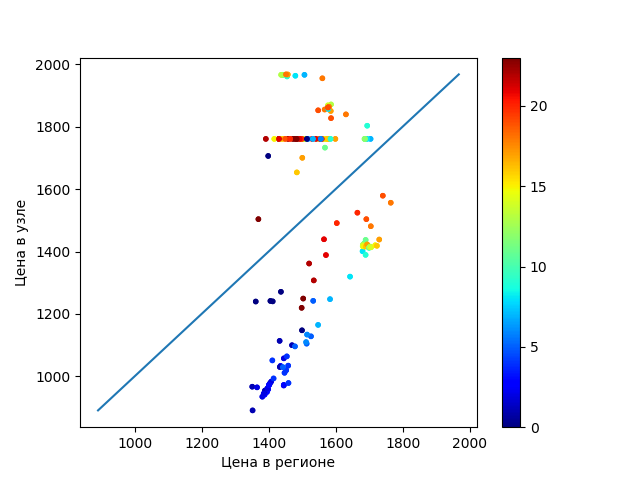

In [21]:
a = node_data.loc[node_data.node_id == 100406, :]
plt.scatter(a.price_pred, a.price, c=a.hour, cmap=plt.get_cmap('jet'), marker='.')
plt.plot([a.price.min(), a.price.max()], [a.price.min(), a.price.max()])
plt.colorbar();
plt.xlabel('Цена в регионе')
plt.ylabel('Цена в узле')
plt.savefig('pic/price4.png', transparent=True)